## LeRobot dataset

Let's load 1 episode from the [LeRobot dataset](https://huggingface.co/datasets/alexis779/so100_ball_cup2) generated via tele-operation.

The episode contains ~ 750 frames.

In [1]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata

dataset_id = 'alexis779/so100_ball_cup'
episode_index = 10

dataset = LeRobotDataset(dataset_id, episodes=[episode_index])

from_idx = dataset.episode_data_index["from"][0].item()
to_idx = dataset.episode_data_index["to"][0].item()
episode_frame_count = to_idx - from_idx
episode_frame_count

/home/alexis/Documents/python/robotics/slobot/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


748

The *Frame Per Second* rate is `25`.

In [2]:
ds_meta = LeRobotDatasetMetadata(dataset_id)
ds_meta.fps

25

The episode duration is ~ 30 sec.

In [3]:
episode_duration = episode_frame_count / ds_meta.fps
episode_duration

29.92

## Frame content

The main input data for training include
- the camera RGB 640 x 480 image, `observation.images.phone`
- the leader robot state, `action`
- the follower robot state, `observation.state`
- the task description, `task` 

In [4]:
frame = dataset[from_idx]
frame

{'observation.images.phone': tensor([[[0.8745, 0.8667, 0.8549,  ..., 0.6314, 0.6510, 0.6863],
          [0.8667, 0.8510, 0.8392,  ..., 0.6510, 0.6667, 0.6784],
          [0.7725, 0.7922, 0.8235,  ..., 0.6863, 0.6784, 0.6745],
          ...,
          [0.8588, 0.8588, 0.8667,  ..., 0.6000, 0.5373, 0.5294],
          [0.8667, 0.8667, 0.8667,  ..., 0.5373, 0.4431, 0.4353],
          [0.8667, 0.8667, 0.8706,  ..., 0.5373, 0.4431, 0.4431]],
 
         [[0.7529, 0.7451, 0.7333,  ..., 0.5333, 0.5529, 0.5882],
          [0.7451, 0.7294, 0.7176,  ..., 0.5529, 0.5686, 0.5804],
          [0.6510, 0.6706, 0.7020,  ..., 0.5922, 0.5843, 0.5804],
          ...,
          [0.7765, 0.7765, 0.7843,  ..., 0.8157, 0.8471, 0.8392],
          [0.7843, 0.7843, 0.7843,  ..., 0.8471, 0.8980, 0.8902],
          [0.7843, 0.7843, 0.7882,  ..., 0.8471, 0.8980, 0.8980]],
 
         [[0.7137, 0.7059, 0.6941,  ..., 0.4667, 0.4863, 0.5216],
          [0.7059, 0.6902, 0.6784,  ..., 0.4863, 0.5020, 0.5137],
          [0

In [5]:
import torch

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=episode_frame_count
)

episode = next(iter(dataloader))

The id of the joint connected to the fixed jaw that opens and closes the mobile jaw is `5`.

In [6]:
gripper_id = 5
frame_ids = episode['frame_index'].cpu()
follower_gripper = episode['action'][:,gripper_id].cpu()
leader_gripper = episode['observation.state'][:,gripper_id].cpu()

## Analysis

The Follower is delayed on the leader by 3 FPS, ~ 75 ms.

### Step 1

The Leader is closed at the beginning in the rest position, corresponding to the `-17` gripper motor position. The Follower is also closed, the position capped at the `-8` position.

<center>
    <img src="../doc/LeaderArm.jpg" alt="Leader Arm" style="width:200px;"/>
</center>

### Step 2

The Leader opens the gripper.

### Step 3

The Leader closes the gripper.

### Step 4

When the Follower holds the ball, the grippers blocks at position `+24`, while the Leader closes all the way.

### Step 5

The Leader opens the gripper. Once the Leader reaches the Follower closed position and passes it to open it, the robotic arm releases the ball, placing it in the cup,

### Step 6

The Leader is closed again until the end, like in the beginning.

In [7]:
delay_frames = 3

truncated_leader = leader_gripper[delay_frames:]
truncated_frame_ids = frame_ids[:-delay_frames]

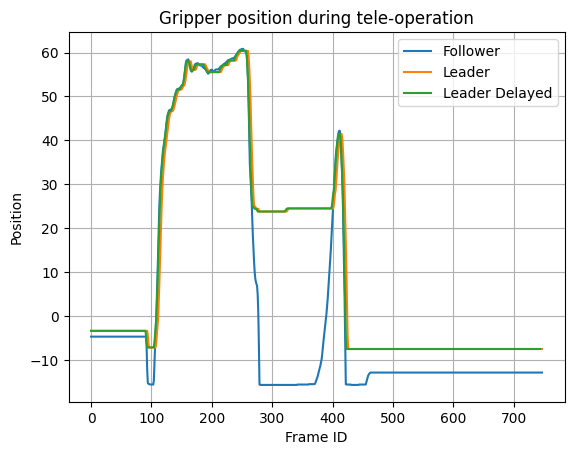

In [8]:

import matplotlib.pyplot as plt

plt.plot(frame_ids, follower_gripper, label='Follower')
plt.plot(frame_ids, leader_gripper, label='Leader')
plt.plot(truncated_frame_ids, truncated_leader, label='Leader Delayed')
plt.xlabel('Frame ID')
plt.ylabel('Position')
plt.title('Gripper position during tele-operation')
plt.legend()
plt.grid(True)

### Hold state

To identify the holding period, apply a threshold on the difference between the Leader & the Follower position.

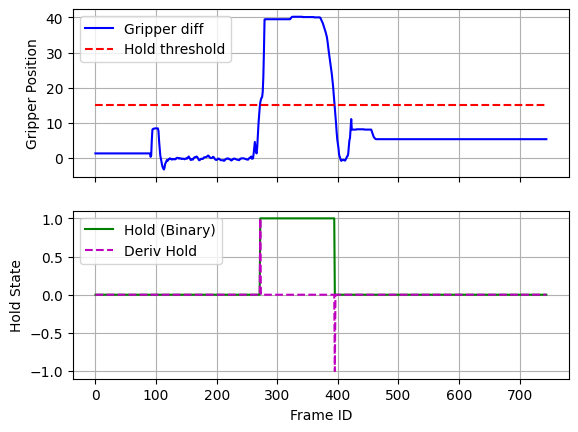

In [9]:

gripper_diff = truncated_leader - follower_gripper[:-delay_frames]
diff_threshold = 15
gripper_threshold = torch.full_like(gripper_diff, fill_value=diff_threshold)


above_threshold = torch.where(gripper_diff > diff_threshold, 1, 0)
above_threshold_derivative = torch.diff(above_threshold, prepend=above_threshold[0:1])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# --- Top Plot: Gripper Diff and Threshold ---
ax1.plot(truncated_frame_ids, gripper_diff, 'b-', label='Gripper diff')
ax1.plot(truncated_frame_ids, gripper_threshold, 'r--', label='Hold threshold')
ax1.set_ylabel('Gripper Position')
ax1.legend(loc='upper left')
ax1.grid(True)

# --- Bottom Plot: Hold and Derivative Signals ---
ax2.plot(truncated_frame_ids, above_threshold, 'g-', label='Hold (Binary)')
ax2.plot(truncated_frame_ids, above_threshold_derivative, 'm--', label='Deriv Hold')
ax2.set_xlabel('Frame ID')
ax2.set_ylabel('Hold State')
ax2.legend(loc='upper left')
ax2.grid(True)


The start and end frames of the holding period provide the pick and the place position respectively.

They identify the original positions of the ball and the cup.

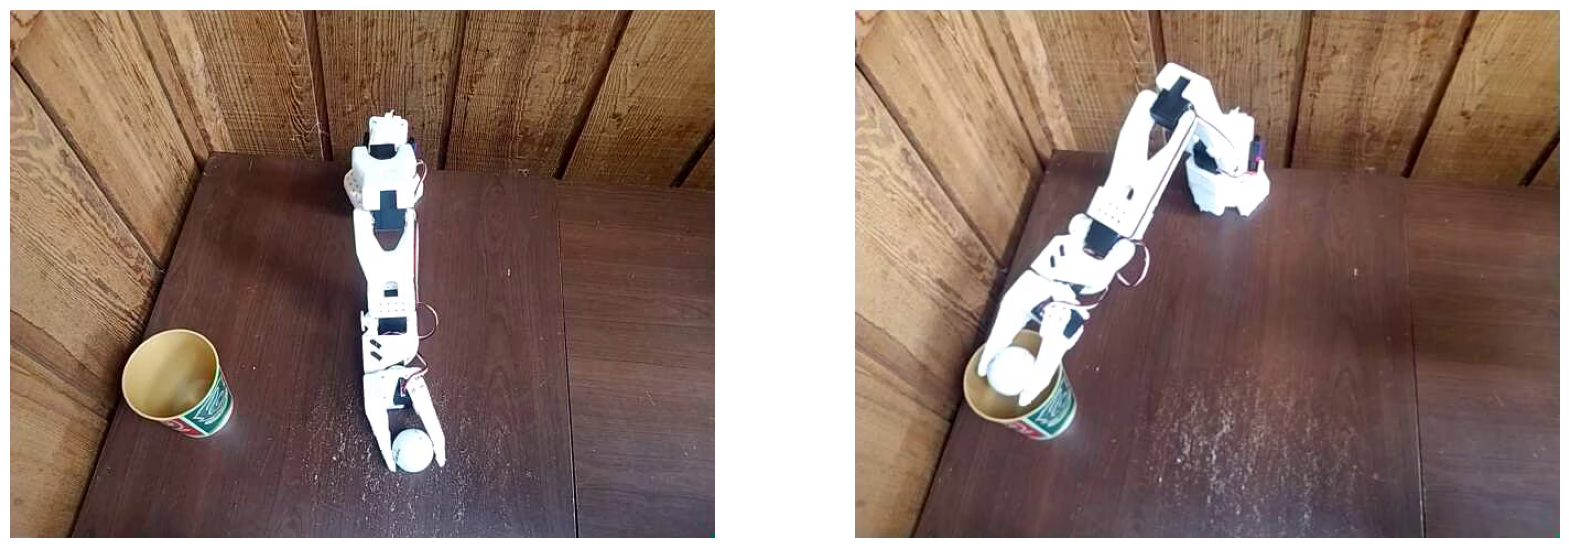

In [10]:
pick_frame_idx, = torch.where(above_threshold_derivative == 1)
place_frame_idx, = torch.where(above_threshold_derivative == -1)
pick_frame_idx = pick_frame_idx.item()
place_frame_idx = place_frame_idx.item()

camera = episode['observation.images.phone']

# Convert tensor to a 2D array of RGB pixels
# Channels x Width x Height -> Width x Height x Channels

pick_img = camera[pick_frame_idx]
pick_img = pick_img.data.numpy()
pick_img = pick_img.transpose(1, 2, 0)

place_img = camera[place_frame_idx]
place_img = place_img.data.numpy()
place_img = place_img.transpose(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(pick_img)
ax1.set_axis_off()
ax2.imshow(place_img)
ax2.set_axis_off()